***
# **Tarea 1 - Análisis de Datos**
***

## **Web scraping, Manejo de datos y Probabilidades**

- **Profesores:**  Ricardo Flores (rflores@inf.udec.cl).
- **Ayudante:** Felipe Burgos Rubilar (felipeiburgos@udec.cl).

- Fecha de entrega: **11/09/25**

- **¿Cómo?:** La tarea debe ser subida a CANVAS en un archivo con el formato **NombreApellido_T1.zip**. Este debe contener el código solicitado, junto con el conjunto de datos utilizado.

***
#### **Normas del curso:**
Antes de comenzar lea detenidamente las normas a aplicar en la evaluación de esta tarea.

- El horario límite para entregar la tarea es a las **23:59** de la fecha señalada en el encabezado. Entregas posteriores a la fecha y hora indicada utilizan uno de sus días permitidos para atraso, en caso de no tener días de atraso disponibles se asigna **nota mínima**. Es por esto que se le recomienda subir la tarea con anticipación.
- Cada respuesta debe ser explicada claramente sin dejar espacio a dobles interpretaciones. **El código de la tarea debe estar comentado.**
- Está bien discutir las respuestas con compañeros/as. Está bien buscar la respuesta en internet. Está bien asistir a clases donde comentaremos como resolver la tarea. **No está bien** entregar código escrito por otras personas ya sea compañeros, código obtenido por internet o incluso el código que el profesor programa en clases.
- **Todo código entregado debe ser escrito completamente por usted**. De lo contrario, su tarea será penalizada con la nota mínima.

***

## **$\bullet$ Parte 1: Web scraping (30 ptos)**
El ayudante quiere comenzar su propio canal de criticas y reseñas sobre series de televisión y películas quieren dar una dura pelea a las grandes influencers como CoffeTV, VSXProject, ZEPfilms, etc. Para esto el ayudante ha consumido cuantas series ha podido. Sin embargo, a el también le gustaría tener información actualizada sobre las series disponibles, en todo momento. El ayudante no han tenido tiempo para realizar esto, por lo cual le solicitan ayuda al curso de “Análisis de Datos” del Departamento de Informática de la UdeC para que les ayuden con el script y el análisis.

En base a esto se le solicita a usted que genere un código que permita extraer la información sobre series de television de la página sensacine.com/series-tv filtrados por género, ya que recopila información de varios géneros y paises y no tiene restricciones de extracción de datos mediante técnicas de scraping (más o menos).

### Los datos que les interesan al ayudante son los siguientes:

**Información que se puede extraer desde la página general:**

- Filtrado según género.

**Información que se puede extraer desde la página por género:**

*Identificacion*
- Nombre de la Serie.

*Puntuación*
- Puntuación de los medios.
- Puntuacion de los usuarios.

*Emision:*
- Año de lanzamiento.
- Año de termino.

**Información que deberán extraer dentro de la página de cada serie:**
- Género y subjeneros.
- Cantidad de temporadas.
- Cantidad de episodios.
- Donde se puede ver (servicio de streaming).

Como habrán aprendido en clases, en el proceso de recolección de datos no siempre encontrarán toda la información en cada uno de los productos, por lo cual deberán decidir en cómo trabajar con estos tipos de datos faltantes. Para esto tendrán que explicar cada decisión tomada para la representación de estos. Para efectos de revisión, todos los datos obtenidos deberán ser guardados en un archivo ".pkl" (pickle), ya que la página es actualizada constantemente.

**Resumen:** En esta primera parte se espera que extraigan la información **(15 pts)**, la almacenen en un DataFrame **(2 pts)**, que limpien los datos **(3 pts)**, generen las variables de interes correspondientes en un formato correcto **(7 pts)**, que expliquen las decisiones tomadas **(3 pts)** y guarden los datos en un archivo “.pkl”.

## IMPORTANTE
El desarrollo principal de este trabajo se realizó en archivos `.py` dentro de mi repositorio personal: [AntoCreed777/Web_Scraping](https://github.com/AntoCreed777/Web_Scraping). Allí se puede consultar el proceso completo y una mejor organización del código, gracias a la estructura modular y la separación en carpetas.

Este Jupyter Notebook fue elaborado únicamente para cumplir con los requisitos de la entrega, adaptando y resumiendo el trabajo realizado en el repositorio original.

En este bloque se importan las librerías necesarias para el análisis de datos y se configuran los parámetros iniciales del proyecto.

In [3]:
import glob
import os
import pickle
import re
import logging
from urllib.parse import urljoin

import requests
from bs4 import BeautifulSoup
import pandas as pd
from dataclasses import dataclass, field
from enum import Enum
from typing import Optional

In [4]:
@dataclass(frozen=True)
class AppSettings:
    """Configuración de la aplicación para URLs base y endpoints."""

    base_url: str = "https://www.sensacine.com/"

    @property
    def series_tv_link(self):
        """Devuelve el enlace completo para la sección de series de TV."""
        return self.base_url + "series-tv/"

    nombre_archivo_pkl: str = "series_tv.pkl"


settings = AppSettings()

Utilizo un DataClass en lugar de trabajar directamente con un DataFrame porque el DataClass facilita el autocompletado en el editor, reduce errores al definir y manipular atributos. Además de asegurar que cada campo tenga el tipo y valor esperado antes de convertir los datos a un DataFrame para el análisis final.

In [5]:
class SerieColumn(Enum):
    """Enum con los nombres de las columnas del DataFrame de series de TV."""

    LINK = "link"
    TITULO = "titulo"
    TITULO_ORIGINAL = "titulo_original"
    GENEROS = "generos"
    CANTIDAD_TEMPORADAS = "cantidad_temporadas"
    CANTIDAD_EPISODIOS_TOTALES = "cantidad_episodios_totales"
    FECHA_EMISION_ORIGINAL = "fecha_emision_original"
    FECHA_EMISION_ULTIMA = "fecha_emision_ultima"
    PUNTUACION = "puntuacion"
    DONDE_VER = "donde_ver"


class SerieNullValues(Enum):
    """Enum para valores nulos por defecto de cada campo en DataFrame."""

    LINK = ""
    TITULO = "Desconocido"
    TITULO_ORIGINAL = "Desconocido"
    GENEROS = "No disponible"
    CANTIDAD_TEMPORADAS = 0
    CANTIDAD_EPISODIOS_TOTALES = 0
    FECHA_EMISION_ORIGINAL = 0
    FECHA_EMISION_ULTIMA = 0
    PUNTUACION = pd.NA
    DONDE_VER = "No disponible"

In [6]:
@dataclass
class DatosSerie:
    """Modelo de datos para almacenar información relevante de una serie de TV."""

    link: str

    titulo: Optional[str] = None
    titulo_original: Optional[str] = None
    generos: Optional[list[str]] = field(default_factory=list)
    cantidad_temporadas: Optional[int] = None
    cantidad_episodios_totales: Optional[int] = None
    fecha_emision_original: Optional[int] = None
    fecha_emision_ultima: Optional[int] = None
    puntuacion: Optional[float] = None
    donde_ver: Optional[list[str]] = field(default_factory=list)

    def to_dict(self):
        """Convierte el objeto DatosSerie en un diccionario usando los campos del dataclass y valores nulos del Enum."""
        result = {}
        for field in self.__dataclass_fields__:
            value = getattr(self, field)
            # Si el valor es None, usa el valor nulo por defecto del Enum
            if value is None:
                value = SerieNullValues[field.upper()].value
            if field in (SerieColumn.GENEROS.value, SerieColumn.DONDE_VER.value):
                value = ", ".join(value) if isinstance(value, list) and value else value
            result[field] = value
        return result

    def __str__(self):
        """Representación en texto de los datos de la serie."""
        fecha_ini = (
            str(self.fecha_emision_original) if self.fecha_emision_original else "Desconocido"
        )
        fecha_fin = (
            str(self.fecha_emision_ultima)
            if self.fecha_emision_ultima
            else "En emisión o desconocido"
        )
        return (
            f"Título: {self.titulo or 'Desconocido'}\n"
            f"Título original: {self.titulo_original or 'Desconocido'}\n"
            f"Géneros: {', '.join(self.generos) if self.generos else 'Ninguno'}\n"
            f"Temporadas: {self.cantidad_temporadas or 'Desconocido'}\n"
            f"Episodios totales: {self.cantidad_episodios_totales or 'Desconocido'}\n"
            f"Fecha emisión: {fecha_ini} - {fecha_fin}\n"
            f"Puntuación: {self.puntuacion if self.puntuacion is not None else 'No disponible'}\n"
            f"Ver en: {', '.join(self.donde_ver) if self.donde_ver else 'No disponible'}\n"
            f"Link: {self.link}"
        )

Funciones que extraen los datos de las series de TV.

In [7]:
def get_soup(link: str) -> BeautifulSoup:
    """Obtiene y parsea el contenido HTML de un enlace usando BeautifulSoup.

    Args:
        link (str): URL a consultar.

    Returns:
        BeautifulSoup: Objeto parseado del HTML.

    Raises:
        ValueError: Si ocurre un error en la petición HTTP.
    """
    try:
        r = requests.get(link)
        r.raise_for_status()
    except requests.RequestException as e:
        raise ValueError(f"Error al realizar el request: {e}")

    return BeautifulSoup(r.content, "html.parser")


def buscar_links_de_series(soup: BeautifulSoup) -> list[DatosSerie]:
    """Busca y retorna los links y títulos de series en el HTML dado.

    Args:
        soup (BeautifulSoup): HTML parseado de la página principal.

    Returns:
        list[DatosSerie]: Lista de objetos DatosSerie con link y título.
    """
    # Busca los contenedores de películas.
    peliculas = soup.find_all("li", class_="mdl")

    datos_serie = []

    for peli in peliculas:
        link = peli.find("a", class_="meta-title-link")

        if link:
            titulo = link.get_text(strip=True)
            href = link["href"]
            url_completa = urljoin(settings.base_url, href)
            datos_serie.append(DatosSerie(link=url_completa, titulo=titulo))

    return datos_serie


def extraer_generos(info) -> list[str]:
    """Extrae los géneros de una serie desde el bloque de información.

    Args:
        info (BeautifulSoup): Bloque HTML con información de la serie.

    Returns:
        list[str]: Lista de géneros encontrados.
    """
    div = info.find("div", class_="meta-body-info")
    if not div:
        return []

    generos_sin_procesar = div.find_all(["a", "span"], class_="dark-grey-link")
    return [g.get_text(strip=True) for g in generos_sin_procesar]


def extraer_titulo_original(info) -> str | None:
    """Extrae el título original de la serie si está disponible.

    Args:
        info (BeautifulSoup): Bloque HTML con información de la serie.

    Returns:
        str | None: Título original o None si no existe.
    """
    div = info.find("div", class_="meta-body-original-title")
    if not div:
        return None

    return div.find("strong").get_text(strip=True)


def extraer_cantidad_temporadas_y_episodios(soup: BeautifulSoup) -> tuple[int | None, int | None]:
    """
    Extrae la cantidad de temporadas y episodios de la serie.

    Args:
        soup (BeautifulSoup): HTML parseado de la página de la serie.

    Returns:
        tuple[int | None, int | None]: Una tupla (temporadas, episodios), cada uno puede ser None si no se encuentra.
    """
    info_serie_stats = soup.find("div", class_="stats-numbers-seriespage")
    if not info_serie_stats:
        return (None, None)

    divs = info_serie_stats.find_all("div", class_="stats-item")
    temporadas = None
    episodios = None
    if len(divs) > 0:
        try:
            temporadas = int(divs[0].get_text(strip=True).split()[0])
        except Exception:
            temporadas = None
    if len(divs) > 1:
        try:
            episodios = int(divs[1].get_text(strip=True).split()[0])
        except Exception:
            episodios = None
    return (temporadas, episodios)


def extraer_fecha_emision(info) -> tuple[int | None, int | None]:
    """
    Extrae las fechas de emisión original y última de la serie.

    Args:
        info (BeautifulSoup): Bloque HTML con información de la serie.

    Returns:
        tuple[int | None, int | None]: Una tupla (año_inicio, año_final), cada uno puede ser None si no se encuentra.
    """
    div = info.find("div", class_="meta-body-info")
    if not div:
        return (None, None)
    texto = div.get_text(" ", strip=True)

    import re

    # Busca patrones como "2013 - 2022" o "2013 - "
    match = re.search(r"(\d{4})\s*-\s*(\d{4})?", texto)
    if match:
        anio_inicio = int(match.group(1))
        anio_final = match.group(2)
        if anio_final and anio_final.isdigit():
            return (anio_inicio, int(anio_final))
        else:
            return (anio_inicio, None)

    # Si solo hay un año
    match = re.search(r"(\d{4})", texto)
    if match:
        return (int(match.group(1)), None)
    return (None, None)


def extraer_puntuacion(soup: BeautifulSoup) -> float | None:
    """Extrae el puntaje de usuarios desde el objeto BeautifulSoup proporcionado."""
    divs = soup.find_all("div", class_="rating-item-content")
    if not divs:
        return None

    def obtener_puntaje(div):
        span_title = div.find("span", class_="rating-title")
        if not span_title or span_title.get_text(strip=True) != "Usuarios":
            return None
        span_puntaje = div.find("span", class_="stareval-note")
        if not span_puntaje:
            return None
        texto = span_puntaje.get_text(strip=True)
        try:
            return float(texto.replace(",", "."))
        except ValueError:
            return None

    for div in divs:
        puntaje = obtener_puntaje(div)
        if puntaje is not None:
            return puntaje
    return None


def extraer_donde_ver(soup: BeautifulSoup) -> list[str]:
    """Extrae las plataformas donde se puede ver la serie.

    Args:
        soup (BeautifulSoup): HTML parseado de la página de la serie.

    Returns:
        list[str]: Lista de plataformas.
    """
    div = soup.find_all("div", class_="provider-tile-primary")
    if not div:
        return []

    return [d.get_text(strip=True) for d in div]


def extraer_datos_de_serie(serie: DatosSerie):
    """Extrae y asigna todos los datos relevantes de una serie.

    Args:
        serie (DatosSerie): Objeto DatosSerie a completar.
    """
    try:
        soup = get_soup(link=serie.link)
    except:
        return

    # Extraer Genero y Sub-Genero
    info_serie = soup.find("div", class_="meta-body")

    serie.generos = extraer_generos(info=info_serie)

    # Extraer el Titulo Original
    serie.titulo_original = extraer_titulo_original(info=info_serie)

    # Extraer cantidad de Temporadas y cantidad de Capitulos Totales
    if temporadas_y_episodios := extraer_cantidad_temporadas_y_episodios(soup=soup):
        serie.cantidad_temporadas = temporadas_y_episodios[0]
        serie.cantidad_episodios_totales = temporadas_y_episodios[1]

    # Extraer fechas de emision original y ultima
    if fechas_emision := extraer_fecha_emision(info=info_serie):
        serie.fecha_emision_original = fechas_emision[0]
        serie.fecha_emision_ultima = fechas_emision[1]

    # Extraer puntuacion
    serie.puntuacion = extraer_puntuacion(soup)

    # Extraer donde se puede ver
    serie.donde_ver = extraer_donde_ver(soup=soup)


def extraer_datos_de_series(series: list[DatosSerie]):
    """Itera sobre una lista de series y extrae sus datos.

    Args:
        series (list[DatosSerie]): Lista de series a procesar.
    """
    for serie in series:
        extraer_datos_de_serie(serie=serie)
        logging.info(serie)

Funciones utilitarias para el manejo de DataFrames.

In [8]:
def datos_series_a_dataframe(series: list[DatosSerie]) -> pd.DataFrame:
    """Convierte una lista de DatosSerie en un DataFrame de pandas."""
    data = []
    for s in series:
        data.append(s.to_dict())
    df = pd.DataFrame(data)
    return df


def limpiar_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Realiza limpieza básica del DataFrame usando los campos del dataclass."""
    for field in DatosSerie.__dataclass_fields__:
        null_value = SerieNullValues[field.upper()].value
        if field in (
            SerieColumn.TITULO.value,
            SerieColumn.TITULO_ORIGINAL.value,
        ):
            df[field] = df[field].fillna(null_value).astype(str).str.strip()
        elif field in (SerieColumn.GENEROS.value, SerieColumn.DONDE_VER.value):
            # Normaliza listas representadas como string
            df[field] = df[field].apply(
                lambda x: (
                    x
                    if isinstance(x, str) and x  # Y no esta vacio
                    else (
                        null_value
                        if isinstance(x, list) and not x  # Lista vacia
                        else (
                            ", ".join(x)
                            if isinstance(x, list)
                            else (
                                str(x)
                                if x is not None  # El "" se considera como None
                                else null_value
                            )
                        )
                    )
                )
            )
        elif field in (
            SerieColumn.FECHA_EMISION_ORIGINAL.value,
            SerieColumn.FECHA_EMISION_ULTIMA.value,
        ):
            df[field] = pd.to_numeric(df[field], errors="coerce").fillna(null_value).astype(int)
        elif field in (
            SerieColumn.CANTIDAD_TEMPORADAS.value,
            SerieColumn.CANTIDAD_EPISODIOS_TOTALES.value,
        ):
            df[field] = pd.to_numeric(df[field], errors="coerce").fillna(null_value).astype(int)
        elif field == SerieColumn.PUNTUACION.value:
            df[field] = pd.to_numeric(df[field], errors="coerce").fillna(null_value)
        elif field == SerieColumn.LINK.value:
            df[field] = df[field].fillna(null_value).astype(str).str.strip()
    return df


def guardar_dataframe_pickle(df: pd.DataFrame, filename: str):
    """Guarda el DataFrame en un archivo pickle."""
    with open(filename, "wb") as f:
        pickle.dump(df, f)

Configuracion de funcion que es meujor que print para el debug de los procesos.

In [9]:
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

Funcion principal para el scraping

In [10]:
def scraping_obtener_links_series(
    desde_pagina: Optional[int] = 1, hasta_pagina: Optional[int] = None
) -> list[DatosSerie]:
    """Obtiene los links de las series de TV desde Sensacine entre las páginas indicadas."""
    series: list[DatosSerie] = []
    link_paginas_a_buscar_base = settings.series_tv_link + "?page="

    if desde_pagina is None:
        contador_paginas = 1
    else:
        contador_paginas = desde_pagina

    series_en_pagina_anterior = None

    while True:
        if hasta_pagina is not None and contador_paginas == hasta_pagina + 1:
            break

        logging.info(f"Se va a leer la pagina {contador_paginas}.")
        link_pagina_a_buscar_actual = link_paginas_a_buscar_base + str(contador_paginas)

        try:
            series_en_pagina = buscar_links_de_series(
                soup=get_soup(link=link_pagina_a_buscar_actual)
            )
        except Exception as e:
            logging.error(f"Error al obtener links de la página {contador_paginas}: {e}")
            break

        if not series_en_pagina:
            logging.error(
                f"No hay series en la pagina actual.\tSe asume que en las siguientes tampoco habra mas."
            )
            break

        if series_en_pagina_anterior is not None and series_en_pagina_anterior == series_en_pagina:
            # Si la página actual es igual a la anterior, se detiene el bucle
            break

        series += series_en_pagina
        series_en_pagina_anterior = series_en_pagina
        contador_paginas += 1

    return series

Ejecucion del scraping en rango de paginas.

In [ ]:
desde_pagina: Optional[int] = 1
hasta_pagina: Optional[int] = None
series_links = scraping_obtener_links_series(desde_pagina=desde_pagina, hasta_pagina=hasta_pagina)

if not series_links:
    print("No hay series a para extraer los datos")
else:
    logging.info(f"Found {len(series_links)} series links.")

2025-09-10 13:15:25,491 - INFO - Se va a leer la pagina 1.
2025-09-10 13:15:27,563 - INFO - Se va a leer la pagina 2.
2025-09-10 13:15:27,990 - INFO - Se va a leer la pagina 3.
2025-09-10 13:15:28,335 - INFO - Se va a leer la pagina 4.
2025-09-10 13:15:28,708 - INFO - Se va a leer la pagina 5.
2025-09-10 13:15:29,898 - INFO - Found 75 series links.


In [10]:
if series_links:
    logging.info("SE EXTRAERAN LOS DATOS DE LAS SERIES")
    extraer_datos_de_series(series_links)

2025-09-10 13:15:29,910 - INFO - SE EXTRAERAN LOS DATOS DE LAS SERIES
2025-09-10 13:15:31,062 - INFO - Título: Miércoles
Título original: Wednesday
Géneros: Comedia, Fantasía, Suspense
Temporadas: 3
Episodios totales: 16
Fecha emisión: 2022 - En emisión o desconocido
Puntuación: 4.2
Ver en: Netflix
Link: https://www.sensacine.com/series/serie-28487/
2025-09-10 13:15:32,045 - INFO - Título: Juego de Tronos
Título original: Game of Thrones
Géneros: Drama, Fantasía
Temporadas: 8
Episodios totales: 73
Fecha emisión: 2011 - 2019
Puntuación: 4.6
Ver en: HBO Max
Link: https://www.sensacine.com/series/serie-7157/
2025-09-10 13:15:33,100 - INFO - Título: El Marginal
Título original: Desconocido
Géneros: Crimen, Drama
Temporadas: 5
Episodios totales: 45
Fecha emisión: 2016 - 2022
Puntuación: 3.8
Ver en: Netflix
Link: https://www.sensacine.com/series/serie-20458/
2025-09-10 13:15:34,215 - INFO - Título: The White Lotus
Título original: Desconocido
Géneros: Comedia, Drama
Temporadas: 3
Episodios t

Se realiza la conversion desde una lista de DataClass a un DataFrame de Pandas.

In [11]:
if series_links:
    df_series = datos_series_a_dataframe(series_links)
    logging.info("DataFrame created.")
    display(df_series.head())

2025-09-10 13:17:03,767 - INFO - DataFrame created.


,link,titulo,titulo_original,generos,cantidad_temporadas,cantidad_episodios_totales,fecha_emision_original,fecha_emision_ultima,puntuacion,donde_ver
0,https://www.sensacine.com/series/serie-28487/,Miércoles,Wednesday,"Comedia, Fantasía, Suspense",3,16,2022,0,4.2,Netflix
1,https://www.sensacine.com/series/serie-7157/,Juego de Tronos,Game of Thrones,"Drama, Fantasía",8,73,2011,2019,4.6,HBO Max
2,https://www.sensacine.com/series/serie-20458/,El Marginal,Desconocido,"Crimen, Drama",5,45,2016,2022,3.8,Netflix
3,https://www.sensacine.com/series/serie-27480/,The White Lotus,Desconocido,"Comedia, Drama",3,21,2021,0,3.5,HBO Max
4,https://www.sensacine.com/series/serie-28359/,El verano en que me enamoré,The Summer I Turned Pretty,"Comedia, Comedia dramática, Drama, Romántico",3,25,2022,0,3.7,Amazon Prime Video


Se limpia y se guarda el DataFrame.

In [12]:
if series_links:
    df_series_cleaned = limpiar_dataframe(df_series)
    logging.info("DataFrame cleaned.")

    # Creacion del nombre definitivo del archivo
    if desde_pagina is None:
        desde_pagina = 1

    if hasta_pagina is None:
        hasta_pagina = "X"

    nombre_archivo = settings.nombre_archivo_pkl
    partes_nombre_archivo = nombre_archivo.split(".")
    nombre_archivo_con_rango = (
        partes_nombre_archivo[0] + f"_{desde_pagina}_{hasta_pagina}." + partes_nombre_archivo[1]
    )

    guardar_dataframe_pickle(df_series_cleaned, nombre_archivo_con_rango)
    logging.info(f"Datos guardados en {nombre_archivo_con_rango}. Total de series: {len(df_series_cleaned)}")

2025-09-10 13:17:04,050 - INFO - DataFrame cleaned.
2025-09-10 13:17:04,067 - INFO - Datos guardados en series_tv_1_5.pkl. Total de series: 75


El siguiente codigo es para fucionar archivos .pkl , desarrolle este codigo debido a que cuando trataba de bajar todas las series de una sola vez la pagina me bloqueaba la conexion, y pues, como yo lo dejaba trabajando por 4 horas o mas esto no me gustaba porque perdia todo el avanze en las descargas, por lo que desidi realizar descargas aprciales y luego fucionarlos en un solo archivo el cual luego se analizara.

In [13]:
"""
    Fusiona todos los archivos pickle de series de TV en un solo DataFrame y lo guarda en un archivo.

    Busca archivos que coincidan con el patrón 'series_tv_*_*.pkl', los carga, concatena y guarda el resultado.
"""

patron = "series_tv_*_*.pkl"
archivos = [f for f in glob.glob(patron) if os.path.basename(f) != settings.nombre_archivo_pkl]

if not archivos:
    print("No se encontraron archivos para fusionar.")
else:
    dfs = []
    for archivo in archivos:
        with open(archivo, "rb") as f:
            df = pickle.load(f)
            dfs.append(df)

    # Concatenar todos los DataFrames
    df_final = pd.concat(dfs, ignore_index=True)

    # Guardar el DataFrame fusionado
    archivo_salida = settings.nombre_archivo_pkl
    with open(archivo_salida, "wb") as f:
        pickle.dump(df_final, f)

    print(f"Datos fusionados guardados en {archivo_salida}. Total de series: {len(df_final)}")
    df_merged = df_final

Datos fusionados guardados en series_tv.pkl. Total de series: 9954


## **$\bullet$ Parte 2: Manejo de datos (30 ptos)**

En primera al ayudante le gustaría un análisis de filtrado de las series a nivel de generos y año de lanzamiento. Para esto le piden a usted que responda las siguientes preguntas:

In [11]:
import matplotlib.pyplot as plt

Se carga el DataFrame desde un archivo.

In [12]:
# Load the merged dataframe
try:
    with open(settings.nombre_archivo_pkl, 'rb') as f:
        df_merged = pickle.load(f)
    print(f"Merged DataFrame loaded successfully. Total series: {len(df_merged)}")
    df_merged = df_merged.drop_duplicates()
    display(df_merged.head())
except FileNotFoundError:
    print(f"Error: Merged pickle file '{settings.nombre_archivo_pkl}' not found.")
    df_merged = None


Merged DataFrame loaded successfully. Total series: 9879


,link,titulo,titulo_original,generos,cantidad_temporadas,cantidad_episodios_totales,fecha_emision_original,fecha_emision_ultima,puntuacion,donde_ver
0,https://www.sensacine.com/series/serie-7570/,Verano azul,Desconocido,"Comedia, Drama",1,19,1981,1982,3.8,No disponible
1,https://www.sensacine.com/series/serie-8409/,Camelot,Desconocido,"Aventura, Fantasía, Romántico",1,10,2011,0,3.4,No disponible
2,https://www.sensacine.com/series/serie-10510/,Rush (US),Desconocido,"Drama, Médico",1,6,2014,0,3.7,No disponible
3,https://www.sensacine.com/series/serie-11462/,"Ni Hao, Kai-Lan",Desconocido,Animación,2,20,2008,2011,3.1,No disponible
4,https://www.sensacine.com/series/serie-17956/,Show Me A Hero,Desconocido,"Drama, Judicial, Suspense",1,6,2015,0,3.0,HBO Max


In [13]:
"""Funciones utilitarias para el análisis de series de TV en el proyecto de Web Scraping."""

def importar_data_frame() -> pd.DataFrame:
    """Importa el DataFrame principal desde el archivo pickle configurado."""
    return pd.read_pickle(settings.nombre_archivo_pkl)


def imprimir_data_frame(
    df: pd.DataFrame,
    mensaje: str,
    columnas: Optional[list[str]] = None,
    cantidad: Optional[int] = None,
):
    """
    Imprime el DataFrame en formato tabla markdown.

    Si se especifica una lista de columnas, solo muestra esas columnas.
    """
    if columnas is not None:
        df = df[columnas]

    print(f"\n{mensaje}")

    if df.empty:
        print("El DataFrame está vacío.")
        return

    if cantidad is None:
        print(df.to_markdown(index=False))
        print(f"Filas mostradas: {len(df)}")
    else:
        print(df.head(cantidad).to_markdown(index=False))


def split_df(df: pd.DataFrame, columna: str) -> tuple[str, pd.DataFrame]:
    """Separa los valores de una columna en listas y expande el DataFrame para tener una fila por cada elemento."""
    COLUMNA_SPLIT = columna + "_split"

    # Separar en listas
    df[COLUMNA_SPLIT] = df[columna].str.split(",")

    # Explode para tener una fila por cada elemento
    df_exploded = df.explode(COLUMNA_SPLIT)

    # Limpiar espacios extra
    df_exploded[COLUMNA_SPLIT] = df_exploded[COLUMNA_SPLIT].str.strip()

    return COLUMNA_SPLIT, df_exploded

### Pregunta 2.1 (4 pts):

* ¿Cuáles servicios de streaming están como opciones disponibles para ver series en la lista de sensacine?
* ¿Cuántas series pueden verse en cada servicio de streaming según la lista de sensacine?

In [14]:
if df_merged is not None:
  def respuesta_donde_ver(df: pd.DataFrame):
      """Muestra una tabla con la cantidad de series disponibles en cada servicio de streaming."""
      DONDE_VER_SPLIT, df_exploded = split_df(df, SerieColumn.DONDE_VER.value)
      conteo = df_exploded[DONDE_VER_SPLIT].value_counts()
      tabla = conteo.reset_index()
      tabla.columns = ["Servicio", "Cantidad"]
      imprimir_data_frame(
          tabla, mensaje="Tabla de cantidad de series por servicio de streaming disponible:"
      )

  respuesta_donde_ver(df_merged)


Tabla de cantidad de series por servicio de streaming disponible:
| Servicio           |   Cantidad |
|:-------------------|-----------:|
| No disponible      |       6126 |
| Netflix            |       1557 |
| Disney+            |        482 |
| Amazon Prime Video |        357 |
| HBO Max            |        282 |
| Movistar Plus+     |        159 |
| Apple TV+          |        156 |
| Filmin             |        123 |
| SkyShowtime        |        116 |
Filas mostradas: 9


### Pregunta 2.2 (4 pts):

¿Como se distribuye la cantidad de géneros en este conjunto de series?

> **Nota**: para el conteo considere repetición de series que contengan más de un género, es decir si una serie tiene 3 generos, esta debe ser contada igualmente en cada categoria.

Para esto se le pide la siguiente tabla:

| Genero | Cantidad |
|:-----------:|:------:|
| Acción  | 38
| Comedia | 286 |
| Drama   | 462 |
| ... | ... |

Ademas, con esta información construya un gráfico de barras. Para esto pueden utilizar la librería **Matplotlib**.

> **Reminder:** Un gráfico siempre debe tener título, labels en el eje x e y, seguir los criterio de Tuffe, etc.


Tabla de cantidad de series por género:
| Género            |   Cantidad |
|:------------------|-----------:|
| Drama             |       3929 |
| Comedia           |       2536 |
| Animación         |       1440 |
| Suspense          |       1154 |
| Crimen            |        919 |
| Documental        |        808 |
| Acción            |        800 |
| Fantasía          |        745 |
| Aventura          |        598 |
| Ciencia ficción   |        556 |
| Romántico         |        529 |
| Familia           |        484 |
| Histórico         |        394 |
| Terror            |        250 |
| Biopic            |        216 |
| Judicial          |        197 |
| Telenovela        |        191 |
| Comedia dramática |        181 |
| Diverso           |        147 |
| Música            |        134 |
| Médico            |         93 |
| Espionaje         |         92 |
| Guerra            |         71 |
| Evento deportivo  |         68 |
| Western           |         53 |
| Comedia musi

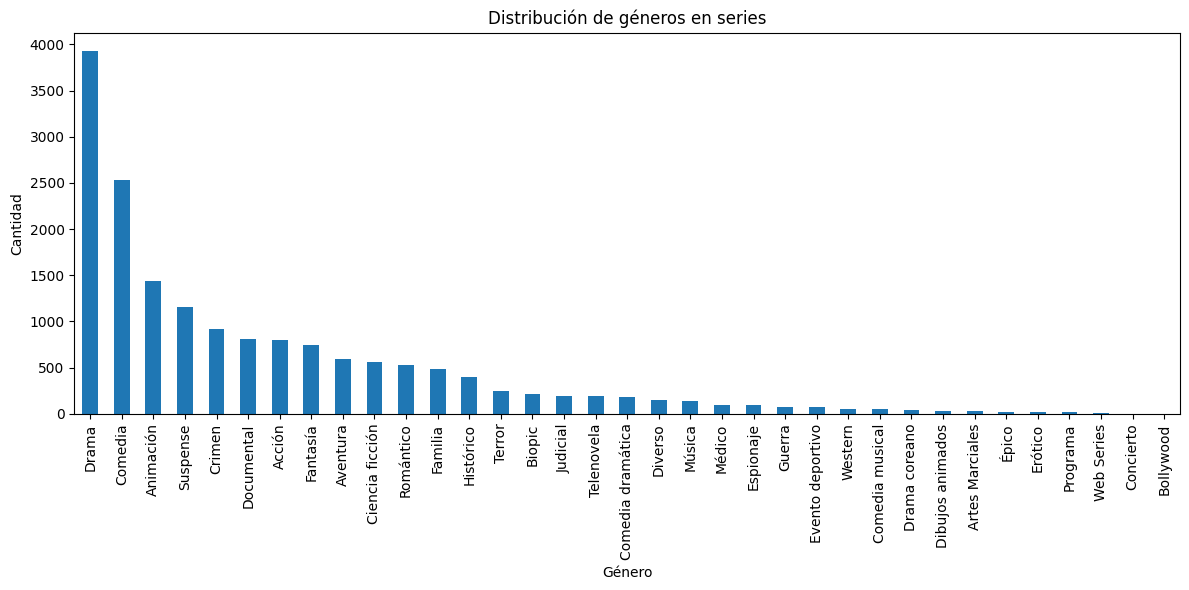

In [15]:
if df_merged is not None:
  def respuesta_generos(df: pd.DataFrame):
      """Analiza y grafica la distribución de géneros en el conjunto de series."""
      GENEROS_SPLIT, df_exploded = split_df(df, SerieColumn.GENEROS.value)

      # Contar cuántas veces aparece cada género
      conteo_generos = df_exploded[GENEROS_SPLIT].value_counts()

      tabla_generos = conteo_generos.reset_index()
      tabla_generos.columns = ["Género", "Cantidad"]
      imprimir_data_frame(tabla_generos, mensaje="Tabla de cantidad de series por género:")

      # Graficar la distribución de géneros
      conteo_generos.plot(kind="bar", figsize=(12, 6))
      plt.xlabel("Género")
      plt.ylabel("Cantidad")
      plt.title("Distribución de géneros en series")
      plt.tight_layout()
      plt.show()

  respuesta_generos(df_merged)

### Pregunta 2.3 (6 pts):

***
- Entregue una tabla con las 30 series con más de 2 temporadas y mayor puntaje hecho por usuarios. muestre solamente nombre, puntaje, cantidad de temporadas y cantidad de episodios

    *Ejemplo.*

| Nombre | Puntaje de usuarios | Temporadas | Episodios |
|:----------------:|:----------------:|:----------------:|:----------------:|
| Serie 1 |  Score 1 | N1|  Neps1 |
| ... | ... | ... | ... |
| Serie 30 | Score 30 | N30 | Neps30 |

***
- Muestre en una tabla el puntaje segun usuarios promedio de todos los generos (redondée a 3 decimales) y luego las estadísticas descriptivas (desviación estándar, promedio, valor máximo y mínimo) de los 3 géneros de series que tengan la mayor puntuación promedio y los 2 generos que tengan la menor puntuación promedio.

    *Ejemplo.*

| Genero   | Puntaje por usuario promedio |xx|
|:--------:|:----------------:|-|
|  Crimen | 3.878 |...|
| ...      | ...       |...|
| Drama coreano | 0.290  |...|

***
- Entregue una tabla con los servicios de streaming, la cantidad de series que se pueden observar en cada uno de ellos y el puntaje por usuario promedio de estas series, redondée a 3 decimales.

    *Ejemplo.*

| Streaming | Cantidad de series | Puntuacion por usuario promedio |
|:----------------:|:----------------:|:--------------|
|  Netflix | xx |xx|
| ... | ... |...|
| Amazon Prime | xx |xx|

***

In [16]:
if df_merged is not None:
  def respuesta_series_con_mas_temporadas_puntaje(df: pd.DataFrame):
      """Muestra una tabla con las 30 series con más de 2 temporadas y mayor puntaje de usuarios."""
      # Filtrar series con más de 2 temporadas
      df_filtrado = df[df[SerieColumn.CANTIDAD_TEMPORADAS.value] > 2]

      # Seleccionar columnas relevantes
      columnas = [
          SerieColumn.TITULO.value,
          SerieColumn.PUNTUACION.value,
          SerieColumn.CANTIDAD_TEMPORADAS.value,
          SerieColumn.CANTIDAD_EPISODIOS_TOTALES.value,
      ]
      df_seleccion = df_filtrado[columnas]

      # Ordenar por puntaje descendente y tomar los 30 primeros
      df_top = df_seleccion.sort_values(by=SerieColumn.PUNTUACION.value, ascending=False).head(30)

      # Renombrar columnas para la tabla
      df_top = df_top.rename(
          columns={
              SerieColumn.TITULO.value: "Nombre",
              SerieColumn.PUNTUACION.value: "Puntaje de usuarios",
              SerieColumn.CANTIDAD_TEMPORADAS.value: "Temporadas",
              SerieColumn.CANTIDAD_EPISODIOS_TOTALES.value: "Episodios",
          }
      )

      imprimir_data_frame(
          df_top, mensaje="Tabla de series con más de 2 temporadas y mayor puntaje de usuarios:"
      )

  def respuesta_puntaje_generos_estadisticas(df: pd.DataFrame):
      """Calcula el puntaje promedio por género y muestra estadísticas descriptivas de los géneros con mayor y menor puntaje."""
      GENEROS_SPLIT, df_exploded = split_df(df, SerieColumn.GENEROS.value)

      # Calcular puntaje promedio por género
      puntaje_por_genero = (
          df_exploded.groupby(GENEROS_SPLIT)[SerieColumn.PUNTUACION.value].mean().round(3)
      )
      tabla = puntaje_por_genero.reset_index().rename(
          columns={
              GENEROS_SPLIT: "Genero",
              SerieColumn.PUNTUACION.value: "Puntaje por usuario promedio",
          }
      )

      imprimir_data_frame(tabla, mensaje="Tabla de puntaje promedio por género:")

      # Seleccionar géneros con mayor y menor puntaje promedio
      top3 = puntaje_por_genero.sort_values(ascending=False).head(3)
      bottom2 = puntaje_por_genero.sort_values(ascending=True).head(2)

      print("\nEstadísticas descriptivas de los 3 géneros con mayor puntaje promedio:")
      for genero in top3.index:
          puntajes = df_exploded[df_exploded[GENEROS_SPLIT] == genero][SerieColumn.PUNTUACION.value]
          print(f"\nGénero: {genero}")
          print(f"Promedio: {puntajes.mean():.3f}")
          print(f"Desviación estándar: {puntajes.std():.3f}")
          print(f"Máximo: {puntajes.max():.3f}")
          print(f"Mínimo: {puntajes.min():.3f}")

      print("\nEstadísticas descriptivas de los 2 géneros con menor puntaje promedio:")
      for genero in bottom2.index:
          puntajes = df_exploded[df_exploded[GENEROS_SPLIT] == genero][SerieColumn.PUNTUACION.value]

          # Calculo de la desviacion estandar
          desv = puntajes.std()
          if pd.isna(desv):
              desv_str = "No aplica"
          else:
              desv_str = f"{desv:.3f}"

          print(f"\nGénero: {genero}")
          print(f"Promedio: {puntajes.mean():.3f}")
          print(f"Desviación estándar: {desv_str}")
          print(f"Máximo: {puntajes.max():.3f}")
          print(f"Mínimo: {puntajes.min():.3f}")

  def respuesta_streaming_cant_series_puntaje(df: pd.DataFrame):
      """Muestra una tabla con la cantidad de series y el puntaje promedio por servicio de streaming."""
      DONDE_VER_SPLIT, df_exploded = split_df(df, SerieColumn.DONDE_VER.value)

      # Se agrupa por Servicio de Streaming
      df_agrupado = df_exploded.groupby(DONDE_VER_SPLIT)

      # Calcular cantidad de series
      cantidad_series = df_agrupado[SerieColumn.TITULO.value].count()

      # Calcular puntaje promedio por servicio
      puntaje_por_servicio = df_agrupado[SerieColumn.PUNTUACION.value].mean().round(3)

      # Unir ambas métricas en una sola tabla
      tabla = pd.DataFrame(
          {
              "Streaming": cantidad_series.index,
              "Cantidad de series": cantidad_series.values,
              "Puntuacion por usuario promedio": puntaje_por_servicio.values,
          }
      )

      imprimir_data_frame(
          tabla, mensaje="Tabla de servicios de streaming, cantidad de series y puntaje promedio:"
      )

  respuesta_series_con_mas_temporadas_puntaje(df_merged)
  respuesta_puntaje_generos_estadisticas(df_merged)
  respuesta_streaming_cant_series_puntaje(df_merged)



Tabla de series con más de 2 temporadas y mayor puntaje de usuarios:
| Nombre                         |   Puntaje de usuarios |   Temporadas |   Episodios |
|:-------------------------------|----------------------:|-------------:|------------:|
| Breaking Bad                   |                   4.7 |            5 |          62 |
| Juego de Tronos                |                   4.6 |            8 |          73 |
| Los Simpson                    |                   4.5 |           36 |         789 |
| Los Soprano                    |                   4.5 |            6 |          86 |
| Peaky Blinders                 |                   4.5 |            6 |          36 |
| Vikingos                       |                   4.5 |            6 |          89 |
| Sherlock                       |                   4.4 |            5 |          14 |
| The Mandalorian                |                   4.4 |            4 |          24 |
| Naruto Shippuden               |                

### Pregunta 2.4 (6 ptos):

*  Entregue una tabla con series que tengan una puntuacion por usuarios entre mínimo 3.5 y máximo 5.0, que tenga como género Drama, que tengan 2 o más Temporadas, que hayan terminado de emitirse y pueda verse en una plataforma de streaming.


*   ¿Cúal es la plataforma de streaming que vale la pena contratar según calidad/cantidad de series de acuerdo con los datos de Sensacine? Justifique su respuesta.

In [17]:
if df_merged is not None:
  def respuesta_series_puntuacion_en_limites(df: pd.DataFrame):
      """Filtra y muestra series con puntaje entre 3.5 y 5, género Drama, 2+ temporadas, terminadas y disponibles en streaming."""
      from datetime import datetime

      # Filtrar por puntaje
      df_filtrado = df[
          (df[SerieColumn.PUNTUACION.value] >= 3.5) & (df[SerieColumn.PUNTUACION.value] <= 5)
      ].copy()

      GENEROS_SPLIT, df_exploded = split_df(df_filtrado, SerieColumn.GENEROS.value)

      # Filtrar por género Drama
      df_exploded = df_exploded[df_exploded[GENEROS_SPLIT] == "Drama"]

      # Filtrar por temporadas
      df_exploded = df_exploded[df_exploded[SerieColumn.CANTIDAD_TEMPORADAS.value] >= 2]

      # Filtrar por series terminadas
      df_exploded = df_exploded[
          (df_exploded[SerieColumn.FECHA_EMISION_ULTIMA.value].notnull())
          & (
              df_exploded[SerieColumn.FECHA_EMISION_ULTIMA.value].astype(int)
              != SerieNullValues.FECHA_EMISION_ULTIMA.value
          )
          & (df_exploded[SerieColumn.FECHA_EMISION_ULTIMA.value].astype(int) > 1900)
          & (df_exploded[SerieColumn.FECHA_EMISION_ULTIMA.value].astype(int) <= datetime.now().year)
      ]

      # Filtrar por disponibilidad en streaming (excluye cualquier "No disponible")
      df_exploded = df_exploded[
          (df_exploded[SerieColumn.DONDE_VER.value].notnull())
          & (~df_exploded[SerieColumn.DONDE_VER.value].str.contains(SerieNullValues.DONDE_VER.value))
      ]

      # Eliminar duplicados por serie y plataforma
      df_exploded = df_exploded.drop_duplicates(
          subset=[
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.CANTIDAD_TEMPORADAS.value,
              SerieColumn.FECHA_EMISION_ULTIMA.value,
              SerieColumn.DONDE_VER.value,
          ]
      )

      imprimir_data_frame(
          df_exploded,
          mensaje="Tabla de series con puntuación entre 3.5 y 5, género Drama, 2+ temporadas, terminadas y disponibles en streaming:",
          columnas=[
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.CANTIDAD_TEMPORADAS.value,
              SerieColumn.FECHA_EMISION_ULTIMA.value,
              SerieColumn.DONDE_VER.value,
          ],
      )

  def respuesta_mejor_plataforma_streaming(df: pd.DataFrame):
      """Calcula y muestra la mejor plataforma de streaming según calidad y cantidad de series."""
      DONDE_VER_SPLIT, df_exploded = split_df(df, SerieColumn.DONDE_VER.value)

      df_exploded = df_exploded[
          (df_exploded[DONDE_VER_SPLIT].notnull())
          & (~df_exploded[SerieColumn.DONDE_VER.value].str.contains(SerieNullValues.DONDE_VER.value))
      ]

      # Se agrupa por Servicio de Streaming
      df_agrupado = df_exploded.groupby(DONDE_VER_SPLIT)

      # Calcular cantidad de series
      cantidad_series = df_agrupado[SerieColumn.TITULO.value].count()

      # Calcular puntaje promedio por servicio
      puntaje_por_servicio = df_agrupado[SerieColumn.PUNTUACION.value].mean()

      # Normalizar ambos valores (min-max)
      min_cant, max_cant = cantidad_series.min(), cantidad_series.max()
      min_punt, max_punt = puntaje_por_servicio.min(), puntaje_por_servicio.max()
      cantidad_series_norm = (
          (cantidad_series - min_cant) / (max_cant - min_cant)
          if max_cant > min_cant
          else cantidad_series * 0
      )
      puntaje_por_servicio_norm = (
          (puntaje_por_servicio - min_punt) / (max_punt - min_punt)
          if max_punt > min_punt
          else puntaje_por_servicio * 0
      )

      # Índice ponderado
      alpha = 0.5
      beta = 0.5
      indice_ponderado = alpha * puntaje_por_servicio_norm + beta * cantidad_series_norm

      # Crear la tabla
      tabla = pd.DataFrame(
          {
              "Streaming": cantidad_series.index,
              "Cantidad de series": cantidad_series.values,
              "Puntaje promedio": puntaje_por_servicio.values,
              "Índice calidad*cantidad (ponderado)": indice_ponderado.values,
          }
      )

      # Ordenar por índice ponderado
      tabla = tabla.sort_values(by="Índice calidad*cantidad (ponderado)", ascending=False)

      imprimir_data_frame(
          tabla,
          mensaje="Mejor plataforma de streaming según índice calidad*cantidad (normalizado y ponderado):",
      )

respuesta_series_puntuacion_en_limites(df_merged)
respuesta_mejor_plataforma_streaming(df_merged)


Tabla de series con puntuación entre 3.5 y 5, género Drama, 2+ temporadas, terminadas y disponibles en streaming:
| titulo                                        |   puntuacion |   cantidad_temporadas |   fecha_emision_ultima | donde_ver                       |
|:----------------------------------------------|-------------:|----------------------:|-----------------------:|:--------------------------------|
| Dance Academy                                 |          4   |                     3 |                   2013 | Amazon Prime Video              |
| Better Than Us                                |          3.7 |                     2 |                   2019 | Netflix                         |
| Star Trek: DS9                                |          3.5 |                     2 |                   1999 | Netflix                         |
| Cleptómanas                                   |          3.5 |                     2 |                   2020 | Netflix                        

### Pregunta 2.5 (5 ptos):

*  Entregue una tabla con series que tengan una puntuacion por usuarios entre mínimo 4 y máximo 5.0, que tenga como género Animación, que hayan sido emitidas durante el ultimo año (2025) y pueda verse en una plataforma de streaming.


*   En base a tu analisis ¿Que serie de animación reciente recomendarias a un fan de la acción? ¿Para un fan de la comedia? Justifique sus respuestas.

In [18]:
if df_merged is not None:
  def respuesta_series_puntaje_4_5_animacion_ultimo_ano_ver(df: pd.DataFrame):
      """Muestra series de animación con puntaje entre 4 y 5, emitidas en el último año y disponibles en streaming."""
      # Filtrar por puntaje
      df_filtrado = df[
          (df[SerieColumn.PUNTUACION.value] >= 4) & (df[SerieColumn.PUNTUACION.value] <= 5)
      ].copy()

      GENEROS_SPLIT, df_exploded = split_df(df_filtrado, SerieColumn.GENEROS.value)

      # Filtrar por género Animación
      df_exploded = df_exploded[df_exploded[GENEROS_SPLIT] == "Animación"]

      # Filtrar por series emitidas en 2025
      df_exploded = df_exploded[df_exploded[SerieColumn.FECHA_EMISION_ORIGINAL.value] == 2025]

      # Filtrar por disponibilidad en streaming
      df_exploded = df_exploded[
          (df_exploded[SerieColumn.DONDE_VER.value].notnull())
          & (~df_exploded[SerieColumn.DONDE_VER.value].str.contains(SerieNullValues.DONDE_VER.value))
      ]

      # Mostrar tabla
      imprimir_data_frame(
          df_exploded,
          mensaje="Tabla de series de animación con puntaje entre 4 y 5, emitidas en 2025 y disponibles en streaming:",
          columnas=[
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.DONDE_VER.value,
          ],
      )

  def respuesta_recomendacion(df: pd.DataFrame):
      """Recomienda series de animación recientes para fans de acción y comedia."""
      GENEROS_SPLIT, df_exploded = split_df(df, SerieColumn.GENEROS.value)

      # Filtrar series de animación emitidas en el último año (2025)
      df_animacion_2025 = df_exploded[
          (df_exploded[GENEROS_SPLIT] == "Animación")
          & (df_exploded[SerieColumn.FECHA_EMISION_ORIGINAL.value] == 2025)
      ]

      # Buscar series que también tengan Acción
      df_accion = df_animacion_2025[
          df_animacion_2025[SerieColumn.GENEROS.value].str.contains("Acción")
      ]

      # Buscar series que también tengan Comedia
      df_comedia = df_animacion_2025[
          df_animacion_2025[SerieColumn.GENEROS.value].str.contains("Comedia")
      ]

      # Ordenar por puntaje descendente
      df_accion_sorted = df_accion.sort_values(by=SerieColumn.PUNTUACION.value, ascending=False)
      df_comedia_sorted = df_comedia.sort_values(by=SerieColumn.PUNTUACION.value, ascending=False)

      # Mostrar recomendación para fans de acción
      imprimir_data_frame(
          df_accion_sorted,
          mensaje="Recomendación de series de animación recientes emitidas en el 2025 para fans de la acción (ordenadas por puntaje):",
          columnas=[
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.DONDE_VER.value,
          ],
      )

      # Mostrar recomendación para fans de comedia
      imprimir_data_frame(
          df_comedia_sorted,
          mensaje="Recomendación de series de animación recientes emitidas en el 2025 para fans de la comedia (ordenadas por puntaje):",
          columnas=[
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.DONDE_VER.value,
          ],
      )

respuesta_series_puntaje_4_5_animacion_ultimo_ano_ver(df_merged)
respuesta_recomendacion(df_merged)



Tabla de series de animación con puntaje entre 4 y 5, emitidas en 2025 y disponibles en streaming:
El DataFrame está vacío.

Recomendación de series de animación recientes emitidas en el 2025 para fans de la acción (ordenadas por puntaje):
| titulo                               |   puntuacion | donde_ver     |
|:-------------------------------------|-------------:|:--------------|
| Devil May Cry                        |          3.3 | Netflix       |
| Tu amigo y vecino Spider-Man         |          3.3 | Disney+       |
| Sakamoto Days                        |          3.2 | No disponible |
| Eyes Of Wakanda                      |          3.1 | Disney+       |
| The Beginning After the End          |          3.1 | No disponible |
| Gachiakuta                           |          3   | No disponible |
| New Saga                             |        nan   | No disponible |
| My Hero Academia: Vigilantes         |        nan   | No disponible |
| Dekin no Mogura: The Earthbound Mole 

### Pregunta 2.6 (5 ptos):

*  Entregue una tabla con series con la serie mejor evaluada por cada año segun su fecha original de emisión.
* Presente un histograma con el puntaje promedio de las series estrenadas durante ese año por cada año.


Tabla de la serie mejor evaluada por cada año de emisión original:
|   fecha_emision_original | titulo                                |   puntuacion | generos                                            | donde_ver                   |
|-------------------------:|:--------------------------------------|-------------:|:---------------------------------------------------|:----------------------------|
|                     1935 | The Miracle Rider                     |          3.1 | Western                                            | No disponible               |
|                     1936 | Flash Gordon's Space Soldiers         |          3   | Fantasía                                           | No disponible               |
|                     1937 | Zorro Rides Again                     |          3.1 | Western                                            | No disponible               |
|                     1938 | Flash Gordon's Trip to Mars           |          3.1 | Fantasía     

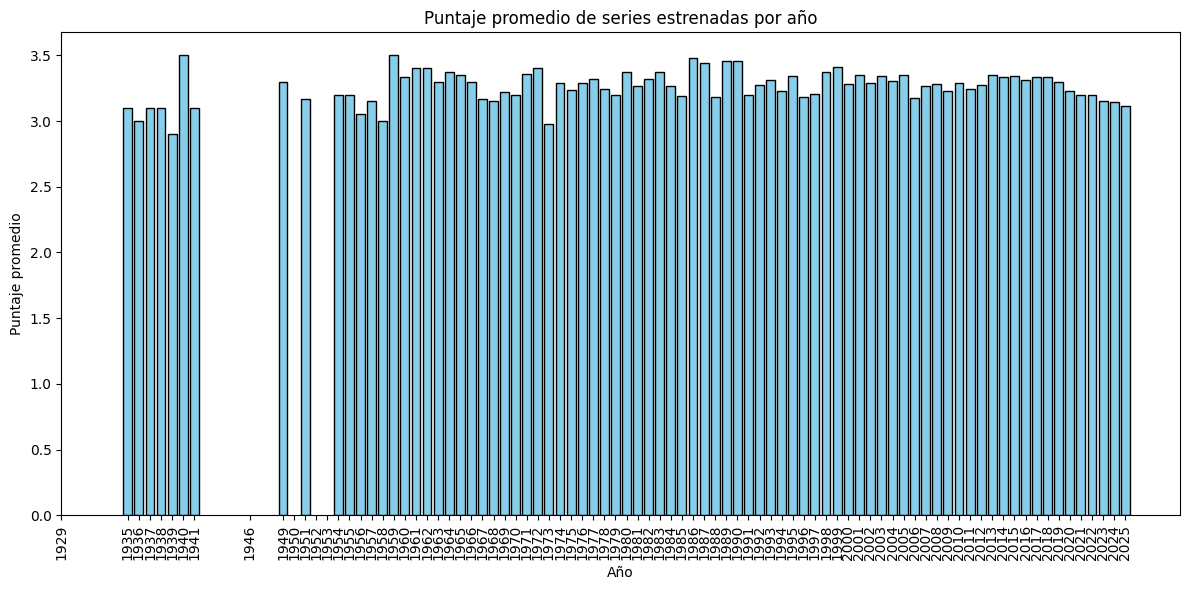

In [21]:
if df_merged is not None:
  def respuesta_series_mejor_evaluadas_por_anio(df: pd.DataFrame):
      """Muestra la serie mejor evaluada por cada año de emisión original."""
      from datetime import datetime

      # Agrupar por año de emisión original y obtener la serie con mayor puntaje en cada año
      df_filtrado = df[
          (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].notnull())
          & (
              df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int)
              != SerieNullValues.FECHA_EMISION_ORIGINAL.value
          )
          & (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int) > 1900)
          & (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int) <= datetime.now().year)
      ]
      idx = df_filtrado.groupby(SerieColumn.FECHA_EMISION_ORIGINAL.value)[
          SerieColumn.PUNTUACION.value
      ].idxmax()

      # Eliminar posibles NaN en idx para evitar KeyError
      idx = idx.dropna()
      df_mejor_por_anio = df_filtrado.loc[idx]

      # Mostrar tabla ordenada por año
      df_mejor_por_anio = df_mejor_por_anio.sort_values(by=SerieColumn.FECHA_EMISION_ORIGINAL.value)
      imprimir_data_frame(
          df_mejor_por_anio,
          mensaje="Tabla de la serie mejor evaluada por cada año de emisión original:",
          columnas=[
              SerieColumn.FECHA_EMISION_ORIGINAL.value,
              SerieColumn.TITULO.value,
              SerieColumn.PUNTUACION.value,
              SerieColumn.GENEROS.value,
              SerieColumn.DONDE_VER.value,
          ],
      )


  def respuesta_puntaje_promedio_por_anio(df: pd.DataFrame):
      """Presenta un histograma con el puntaje promedio de las series estrenadas por año."""
      from datetime import datetime

      df_filtrado = df[
          (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].notnull())
          & (
              df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int)
              != SerieNullValues.FECHA_EMISION_ORIGINAL.value
          )
          & (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int) > 1900)
          & (df[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int) <= datetime.now().year)
      ]

      df_agrupado = df_filtrado.groupby(SerieColumn.FECHA_EMISION_ORIGINAL.value)[
          SerieColumn.PUNTUACION.value
      ].mean()
      df_tabla = df_agrupado.reset_index()

      # Graficar puntaje promedio por año (gráfico de barras)
      plt.figure(figsize=(12, 6))
      anios = df_tabla[SerieColumn.FECHA_EMISION_ORIGINAL.value].astype(int)
      plt.bar(anios, df_tabla[SerieColumn.PUNTUACION.value], color="skyblue", edgecolor="black")
      plt.xlabel("Año")
      plt.ylabel("Puntaje promedio")
      plt.title("Puntaje promedio de series estrenadas por año")
      plt.xticks(anios, rotation=90)
      plt.tight_layout()
      plt.show()

respuesta_series_mejor_evaluadas_por_anio(df_merged)
respuesta_puntaje_promedio_por_anio(df_merged)